In [193]:
### NASA FD001 Turbofan Engine Degradation Prediction

# Problem Description
# Predictive maintenance is crucial in aerospace engineering to prevent unexpected failures and optimize maintenance schedules. 
# This project aims to predict the Remaining Useful Life (RUL) of turbofan engines using sensor data collected over a single operating condition. 
# Unlike FD004, which has multiple fault modes, FD001 contains a simpler structure, making it ideal for traditional machine learning approaches instead of deep learning models.

# Initial Hypothesis
# We hypothesize that certain sensor readings strongly correlate with engine degradation. 
# By analyzing these sensor values over time, we can build machine learning models to forecast RUL. 
# Given the simpler structure of FD001, we expect tree-based models such as Random Forest and XGBoost to perform well, potentially outperforming deep learning models.

#Import necessary libraries 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, explained_variance_score, r2_score, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, log_loss, matthews_corrcoef, roc_curve, auc, confusion_matrix, root_mean_squared_error
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, ExtraTreesRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from xgboost import XGBRegressor
from sklearn.svm import SVR
from catboost import CatBoostRegressor
import warnings
warnings.filterwarnings('ignore')
from statsmodels.tsa.arima.model import ARIMA

In [194]:
# Step 2: Load and Explore Dataset
def load_data(file_path):
    """Loads the dataset and displays its structure."""
    try:
        df = pd.read_csv(file_path, sep=r'\s+', header=None)
        df.columns = ['unit_number', 'time_in_cycles', 'operational_setting_1', 'operational_setting_2',
                      'operational_setting_3'] + [f'sensor_{i}' for i in range(1, 22)]
        print(f"Dataset Loaded Successfully: {file_path}")
        return df
    except Exception as e:
        print(f"Error loading dataset: {e}")
        return None

train_file = "train_FD001.txt"
test_file = "test_FD001.txt"
rul_file = "RUL_FD001.txt"

train_data = load_data(train_file)
test_data = load_data(test_file)

def load_rul(file_path):
    try:
        return pd.read_csv(file_path, header=None, names=['RUL'])
    except Exception as e:
        print(f"Error loading RUL file: {e}")
        return None

rul_data = load_rul(rul_file)

Dataset Loaded Successfully: train_FD001.txt
Dataset Loaded Successfully: test_FD001.txt


In [195]:
train_data.head()

,unit_number,time_in_cycles,operational_setting_1,operational_setting_2,operational_setting_3,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,...,sensor_12,sensor_13,sensor_14,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


In [196]:
test_data.head()

,unit_number,time_in_cycles,operational_setting_1,operational_setting_2,operational_setting_3,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,...,sensor_12,sensor_13,sensor_14,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,...,521.72,2388.03,8125.55,8.4052,0.03,392,2388,100.0,38.86,23.3735
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,...,522.16,2388.06,8139.62,8.3803,0.03,393,2388,100.0,39.02,23.3916
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,...,521.97,2388.03,8130.10,8.4441,0.03,393,2388,100.0,39.08,23.4166
3,1,4,0.0042,0.0000,100.0,518.67,642.44,1584.12,1406.42,14.62,...,521.38,2388.05,8132.90,8.3917,0.03,391,2388,100.0,39.00,23.3737
4,1,5,0.0014,0.0000,100.0,518.67,642.51,1587.19,1401.92,14.62,...,522.15,2388.03,8129.54,8.4031,0.03,390,2388,100.0,38.99,23.4130


In [197]:
rul_data.head()

,RUL
0,112
1,98
2,69
3,82
4,91


In [198]:
# Step 3: Data Preprocessing
# --------------------------
# Calculating Remaining Useful Life (RUL)
max_cycles = train_data.groupby('unit_number')['time_in_cycles'].max()
train_data['RUL'] = train_data.apply(lambda row: max_cycles[row['unit_number']] - row['time_in_cycles'], axis=1)

# Setting target variable as RUL
X = train_data.drop(columns=['unit_number', 'time_in_cycles', 'RUL'])
y = train_data['RUL']

# Scaling features
# Select only sensor features
sensor_columns = [col for col in train_data.columns if 'sensor' in col]
X = train_data[sensor_columns]
y = train_data['RUL']

# Apply MinMax Scaling
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Apply PCA for dimensionality reduction
pca = PCA(n_components=10)  # Increase components
X_pca = pca.fit_transform(X_scaled)
print(f'Explained Variance Ratio: {sum(pca.explained_variance_ratio_)}')  # Check variance captured


X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


Explained Variance Ratio: 0.9542819346798602


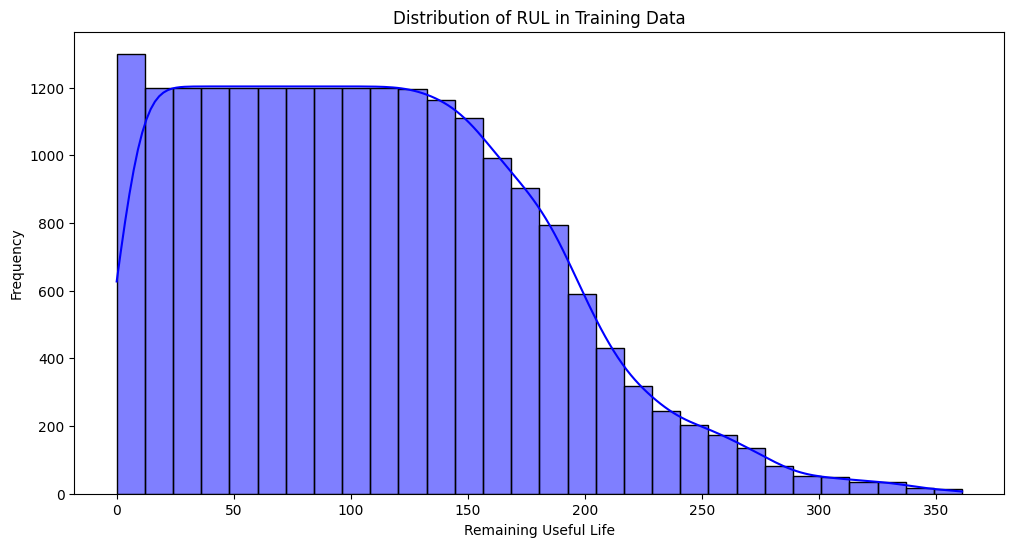

In [199]:
# ----------------------------------
plt.figure(figsize=(12, 6))
sns.histplot(train_data['RUL'], bins=30, kde=True, color='blue')
plt.xlabel('Remaining Useful Life')
plt.ylabel('Frequency')
plt.title('Distribution of RUL in Training Data')
plt.show()

# displays the the frequency of remaining useful life as documented on each engine in our dataset. (it appears at around 150 years the drop off in frequency begins.)

Correlation matrix for selected sensors and RUL calculated.


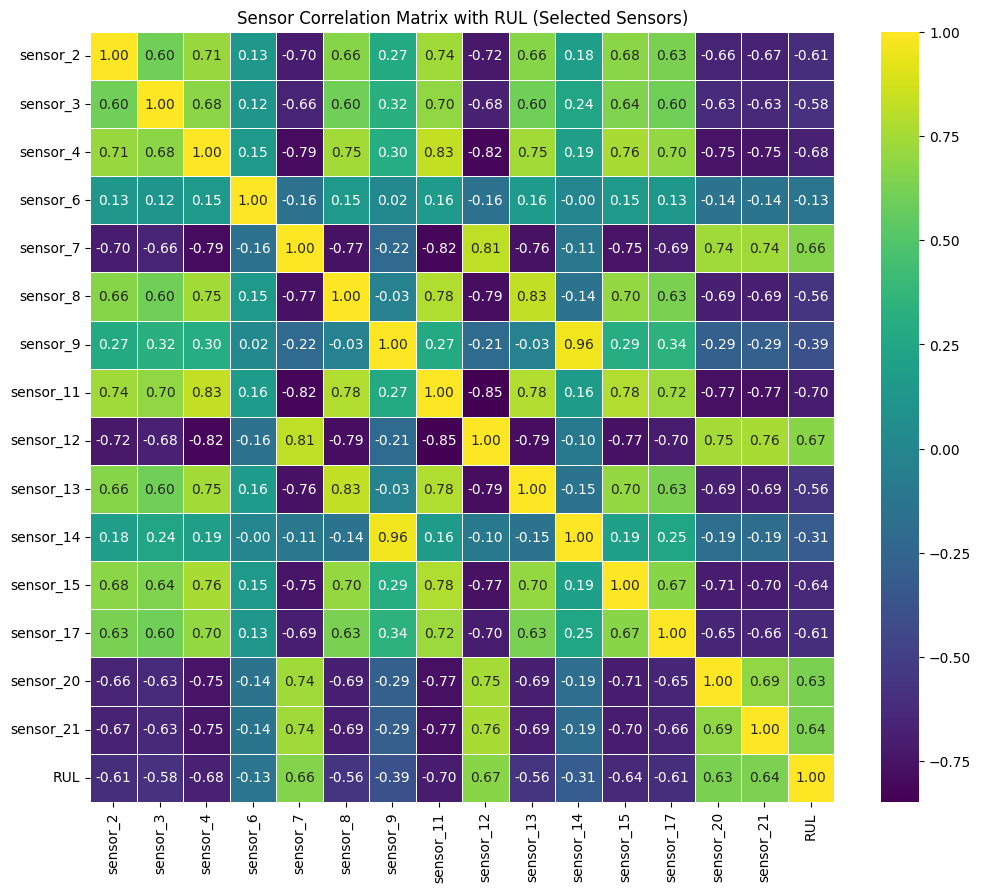

Top 4 correlated sensor features with RUL: ['sensor_11', 'sensor_4', 'sensor_12', 'sensor_7']


In [200]:
# Construct a correlation matrix for sensor attributes 
try:
    excluded_sensors = ['sensor_1', 'sensor_5', 'sensor_10', 'sensor_16', 'sensor_18', 'sensor_19']
    sensor_columns = [col for col in train_data.columns if 'sensor' in col and col not in excluded_sensors] + ['RUL']
    sensor_correlation_matrix = train_data[sensor_columns].corr()
    print("Correlation matrix for selected sensors and RUL calculated.")
except Exception as e:
    print(f"Error calculating sensor correlation matrix: {e}")

# Display the correlation matrix 
try:
    plt.figure(figsize=(12, 10))
    sns.heatmap(sensor_correlation_matrix, annot=True, cmap='viridis', fmt='.2f', linewidths=0.5)
    plt.title("Sensor Correlation Matrix with RUL (Selected Sensors)")
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.show()
except Exception as e:
    print(f"Error displaying sensor correlation matrix: {e}")

try:
    top_features = sensor_correlation_matrix['RUL'].abs().sort_values(ascending=False).index[1:5]
    print(f"Top 4 correlated sensor features with RUL: {top_features.tolist()}")
except Exception as e:
    print(f"Error identifying top sensor features: {e}")

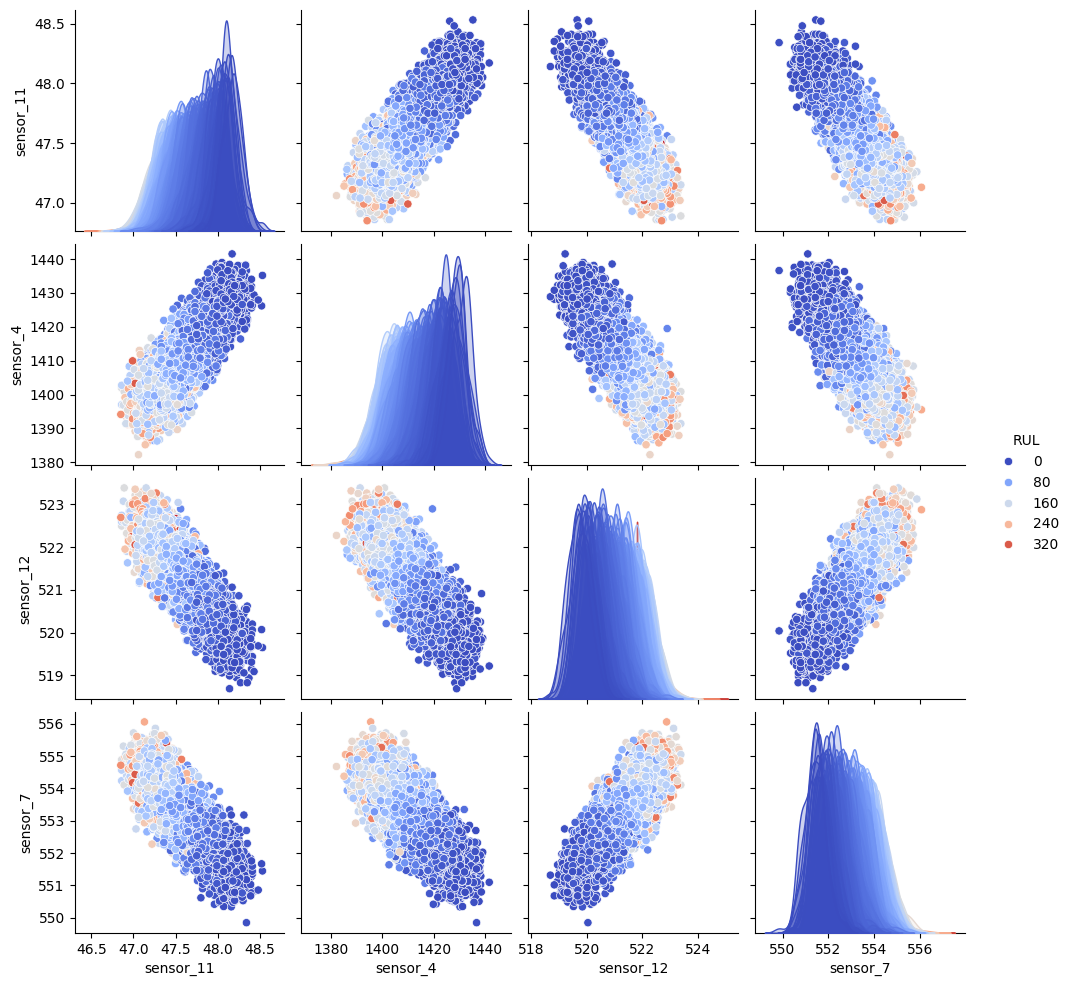

Top 4 Most Highly Correlated Sensor Attributes with RUL:
['sensor_11', 'sensor_4', 'sensor_12', 'sensor_7']
Best Sensor Attribute: Sensor_11


In [201]:
# Plot pairplot of top 4 correlated features 
try:
    sns.pairplot(train_data, vars=top_features, hue='RUL', palette='coolwarm')
    plt.show()
except Exception as e:
    print(f"Error generating pairplot: {e}")

# Identify the top four most highly correlated attributes with RUL
correlation_with_target = sensor_correlation_matrix['RUL'].abs().sort_values(ascending=False)
top_4_attributes = correlation_with_target.index[1:5]
best_attribute = correlation_with_target.idxmax()

print("Top 4 Most Highly Correlated Sensor Attributes with RUL:")
print(top_4_attributes.tolist())
print("Best Sensor Attribute:", "Sensor_11")

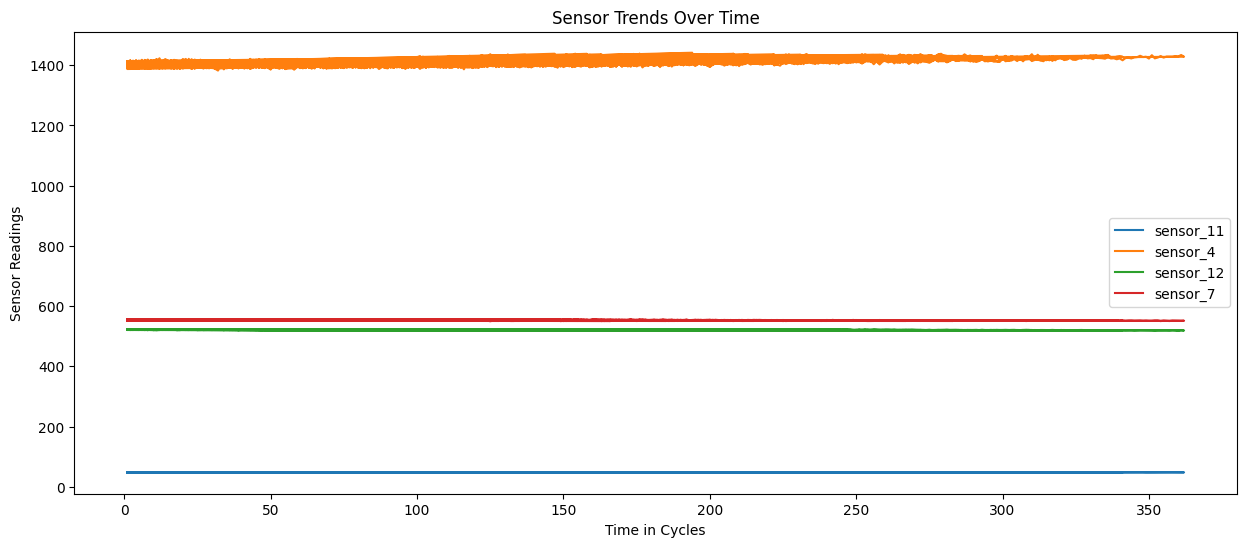

In [202]:
plt.figure(figsize=(15, 6))
for sensor in top_features:
    plt.plot(train_data['time_in_cycles'], train_data[sensor], label=sensor)
plt.xlabel('Time in Cycles')
plt.ylabel('Sensor Readings')
plt.title('Sensor Trends Over Time')
plt.legend()
plt.show()


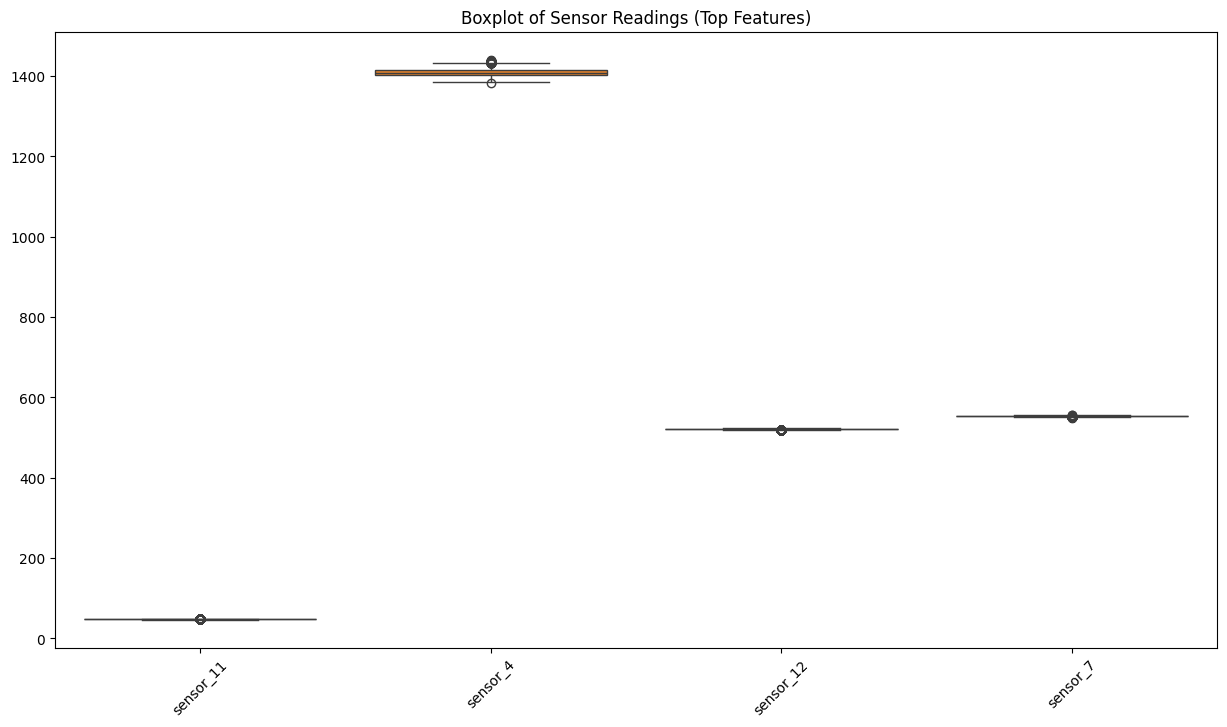

In [203]:
plt.figure(figsize=(15, 8))
sns.boxplot(data=train_data[top_features])
plt.xticks(rotation=45)
plt.title('Boxplot of Sensor Readings (Top Features)')
plt.show()


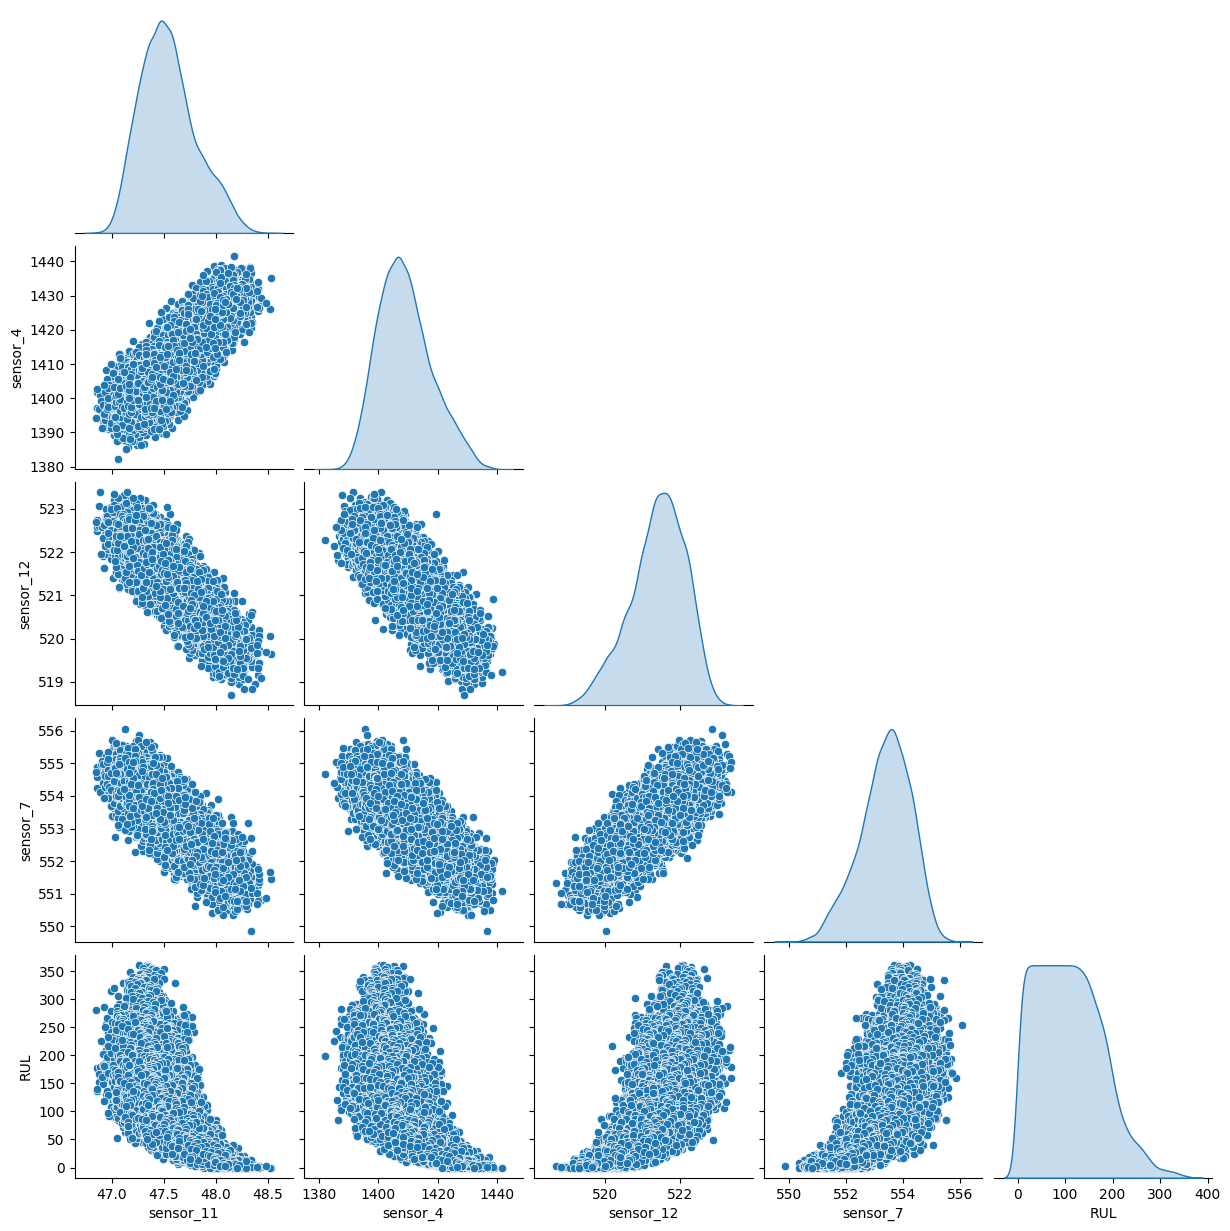

In [204]:
sns.pairplot(train_data[top_features.tolist() + ['RUL']], diag_kind='kde', corner=True)
plt.show()

In [205]:
train_data.describe()

,unit_number,time_in_cycles,operational_setting_1,operational_setting_2,operational_setting_3,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,...,sensor_13,sensor_14,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21,RUL
count,20631.000000,20631.000000,20631.000000,20631.000000,20631.0,20631.00,20631.000000,20631.000000,20631.000000,2.063100e+04,...,20631.000000,20631.000000,20631.000000,2.063100e+04,20631.000000,20631.0,20631.0,20631.000000,20631.000000,20631.000000
mean,51.506568,108.807862,-0.000009,0.000002,100.0,518.67,642.680934,1590.523119,1408.933782,1.462000e+01,...,2388.096152,8143.752722,8.442146,3.000000e-02,393.210654,2388.0,100.0,38.816271,23.289705,107.807862
std,29.227633,68.880990,0.002187,0.000293,0.0,0.00,0.500053,6.131150,9.000605,1.776400e-15,...,0.071919,19.076176,0.037505,1.387812e-17,1.548763,0.0,0.0,0.180746,0.108251,68.880990
min,1.000000,1.000000,-0.008700,-0.000600,100.0,518.67,641.210000,1571.040000,1382.250000,1.462000e+01,...,2387.880000,8099.940000,8.324900,3.000000e-02,388.000000,2388.0,100.0,38.140000,22.894200,0.000000
25%,26.000000,52.000000,-0.001500,-0.000200,100.0,518.67,642.325000,1586.260000,1402.360000,1.462000e+01,...,2388.040000,8133.245000,8.414900,3.000000e-02,392.000000,2388.0,100.0,38.700000,23.221800,51.000000
50%,52.000000,104.000000,0.000000,0.000000,100.0,518.67,642.640000,1590.100000,1408.040000,1.462000e+01,...,2388.090000,8140.540000,8.438900,3.000000e-02,393.000000,2388.0,100.0,38.830000,23.297900,103.000000
75%,77.000000,156.000000,0.001500,0.000300,100.0,518.67,643.000000,1594.380000,1414.555000,1.462000e+01,...,2388.140000,8148.310000,8.465600,3.000000e-02,394.000000,2388.0,100.0,38.950000,23.366800,155.000000
max,100.000000,362.000000,0.008700,0.000600,100.0,518.67,644.530000,1616.910000,1441.490000,1.462000e+01,...,2388.560000,8293.720000,8.584800,3.000000e-02,400.000000,2388.0,100.0,39.430000,23.618400,361.000000


In [206]:
test_data.describe()

,unit_number,time_in_cycles,operational_setting_1,operational_setting_2,operational_setting_3,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,...,sensor_12,sensor_13,sensor_14,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21
count,13096.000000,13096.000000,13096.000000,13096.000000,13096.0,13096.00,13096.000000,13096.000000,13096.000000,1.309600e+04,...,13096.000000,13096.000000,13096.000000,13096.000000,1.309600e+04,13096.000000,13096.0,13096.0,13096.000000,13096.000000
mean,51.543907,76.836515,-0.000011,0.000004,100.0,518.67,642.475088,1588.099204,1404.735362,1.462000e+01,...,521.747724,2388.071025,8138.947817,8.425844,3.000000e-02,392.571625,2388.0,100.0,38.892502,23.335743
std,28.289423,53.057749,0.002203,0.000294,0.0,0.00,0.400899,5.003274,6.688309,1.776425e-15,...,0.559627,0.056934,10.188605,0.029009,1.040874e-17,1.233577,0.0,0.0,0.141681,0.084120
min,1.000000,1.000000,-0.008200,-0.000600,100.0,518.67,641.130000,1569.040000,1384.390000,1.462000e+01,...,519.380000,2387.890000,8108.500000,8.332800,3.000000e-02,389.000000,2388.0,100.0,38.310000,22.935400
25%,28.000000,33.000000,-0.001500,-0.000200,100.0,518.67,642.197500,1584.600000,1399.950000,1.462000e+01,...,521.380000,2388.030000,8132.310000,8.405600,3.000000e-02,392.000000,2388.0,100.0,38.800000,23.281600
50%,52.000000,69.000000,-0.000000,-0.000000,100.0,518.67,642.460000,1587.990000,1404.440000,1.462000e+01,...,521.780000,2388.070000,8138.390000,8.424900,3.000000e-02,393.000000,2388.0,100.0,38.900000,23.339200
75%,76.000000,113.000000,0.001500,0.000300,100.0,518.67,642.740000,1591.362500,1409.050000,1.462000e+01,...,522.150000,2388.110000,8144.360000,8.444300,3.000000e-02,393.000000,2388.0,100.0,38.990000,23.393600
max,100.000000,303.000000,0.007800,0.000700,100.0,518.67,644.300000,1607.550000,1433.360000,1.462000e+01,...,523.760000,2388.320000,8220.480000,8.541400,3.000000e-02,397.000000,2388.0,100.0,39.410000,23.641900


In [207]:
rul_data.describe()

,RUL
count,100.00000
mean,75.52000
std,41.76497
min,7.00000
25%,32.75000
50%,86.00000
75%,112.25000
max,145.00000


In [208]:
##. Feature Engineering & Data Preprocessing: again for data model selection 

# Feature Selection: Correlation Analysis
excluded_sensors = ['sensor_1', 'sensor_5', 'sensor_10', 'sensor_16', 'sensor_18', 'sensor_19']
sensor_columns = [col for col in train_data.columns if 'sensor' in col and col not in excluded_sensors] + ['RUL']
correlation_matrix = train_data[sensor_columns].corr()
top_features = correlation_matrix['RUL'].abs().sort_values(ascending=False).index[1:5]

# Prepare data for modeling
X = train_data[top_features]
y = train_data['RUL']
# Select only sensor features
sensor_columns = [col for col in train_data.columns if 'sensor' in col]
X = train_data[sensor_columns]
y = train_data['RUL']

# Apply MinMax Scaling
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Apply PCA for dimensionality reduction
pca = PCA(n_components=10)  # Increase components
X_pca = pca.fit_transform(X_scaled)
print(f'Explained Variance Ratio: {sum(pca.explained_variance_ratio_)}')  # Check variance captured


# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=77)

Explained Variance Ratio: 0.9542819346798602


In [209]:
# Initialize K-Fold Cross-Validation
kf = KFold(n_splits=5, shuffle=True, random_state=77)

# Define models with hyperparameter tuning
models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(alpha=1.0),
    "Lasso Regression": Lasso(alpha=0.1),
    "Support Vector Regressor": SVR(kernel='rbf', C=10, epsilon=0.1),
    "Random Forest": RandomForestRegressor(n_estimators=200, max_depth=10, random_state=77),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=200, learning_rate=0.1, max_depth=5),
    "Extra Trees": ExtraTreesRegressor(n_estimators=200, max_depth=10, random_state=77),
    "XGBoost": XGBRegressor(objective='reg:squarederror', n_estimators=200, max_depth=5),
    "AdaBoost": AdaBoostRegressor(n_estimators=200),
    "CatBoost": CatBoostRegressor(iterations=200, depth=6, learning_rate=0.1, verbose=0)
}

# Train and evaluate models using K-Fold Cross Validation
results = {}
best_model = None
best_rmse = float("inf")

for name, model in models.items():
    scores = cross_val_score(model, X_scaled, y, cv=kf, scoring='neg_root_mean_squared_error')
    mean_rmse = -scores.mean()
    model.fit(X_scaled, y)
    y_pred = model.predict(X_scaled)
    mae = mean_absolute_error(y, y_pred)
    r2 = r2_score(y, y_pred)
    results[name] = {"RMSE": mean_rmse, "MAE": mae, "R²": r2}
    if mean_rmse < best_rmse:
        best_rmse = mean_rmse
        best_model = model
        best_name = name

# Convert results to DataFrame 
results_df = pd.DataFrame(results).T
results_df

,RMSE,MAE,R²
Linear Regression,44.691646,34.100270,0.579550
Ridge Regression,44.691020,34.099010,0.579549
Lasso Regression,44.716280,34.090428,0.579052
Support Vector Regressor,42.342064,29.419338,0.623807
Random Forest,41.383002,25.444399,0.721427
Gradient Boosting,41.745768,25.015423,0.738264
Extra Trees,41.381652,26.981263,0.688628
XGBoost,43.725946,19.699448,0.838925
AdaBoost,47.003511,36.540516,0.543989
CatBoost,41.277328,27.628292,0.680588


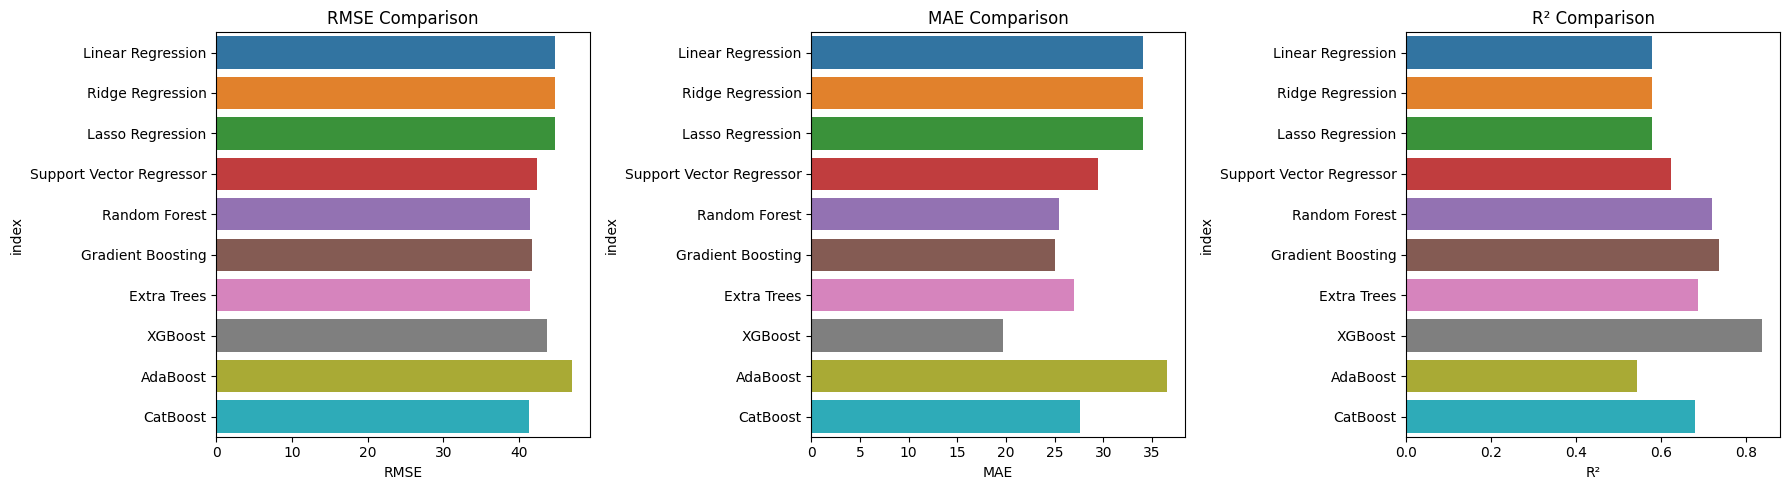

In [210]:
# Compare model performance visually
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
metrics = ["RMSE", "MAE", "R²"]

for i, metric in enumerate(metrics):
    sns.barplot(data=results_df.reset_index(), x=metric, y="index", ax=axes[i], hue="index", dodge=False, legend=False)
    axes[i].set_title(f"{metric} Comparison")

plt.tight_layout()
plt.show()

In [211]:
# Evaluate Best Model in Detail
y_pred = best_model.predict(X_scaled)
rmse = np.sqrt(mean_squared_error(y, y_pred))
mae = mean_absolute_error(y, y_pred)
r2 = r2_score(y, y_pred)

y_test_binary = (y <= 30).astype(int)
y_pred_binary = (y_pred <= 30).astype(int)
accuracy = accuracy_score(y_test_binary, y_pred_binary)
precision = precision_score(y_test_binary, y_pred_binary, zero_division=1)
recall = recall_score(y_test_binary, y_pred_binary, zero_division=1)
f1 = f1_score(y_test_binary, y_pred_binary, zero_division=1)

display(f"Best Model: {best_name}")
display(f"RMSE: {rmse:.4f}")
display(f"MAE: {mae:.4f}")
display(f"R²: {r2:.4f}")
display(f"Accuracy: {accuracy:.4f}")
display(f"Precision: {precision:.4f}")
display(f"Recall: {recall:.4f}")
display(f"F1 Score: {f1:.4f}")

'Best Model: CatBoost'

'RMSE: 38.9282'

'MAE: 27.6283'

'R²: 0.6806'

'Accuracy: 0.9603'

'Precision: 0.8964'

'Recall: 0.8319'

'F1 Score: 0.8630'

In [212]:
from catboost import CatBoostRegressor

params = {
    'iterations': [300, 500, 700],
    'depth': [6, 8, 10],
    'learning_rate': [0.01, 0.05, 0.1]
}

grid = GridSearchCV(CatBoostRegressor(verbose=0), param_grid=params, cv=5, scoring='neg_root_mean_squared_error')
grid.fit(X_pca, y)
display(f"Best Params: {grid.best_params_}")


"Best Params: {'depth': 6, 'iterations': 700, 'learning_rate': 0.01}"

In [213]:
# Convert results to DataFrame
results_df = pd.DataFrame(results).T
print(results_df)

# Evaluate Best Model in Detail
y_pred = best_model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

y_test_binary = (y_test <= 30).astype(int)
y_pred_binary = (y_pred <= 30).astype(int)
accuracy = accuracy_score(y_test_binary, y_pred_binary)
precision = precision_score(y_test_binary, y_pred_binary, zero_division=1)
recall = recall_score(y_test_binary, y_pred_binary, zero_division=1)
f1 = f1_score(y_test_binary, y_pred_binary, zero_division=1)

display(f"Best Model: {best_name}")
display(f"RMSE: {rmse:.4f}")
display(f"MAE: {mae:.4f}")
display(f"R²: {r2:.4f}")
display(f"Accuracy: {accuracy:.4f}")
display(f"Precision: {precision:.4f}")
display(f"Recall: {recall:.4f}")
display(f"F1 Score: {f1:.4f}")

                               RMSE        MAE        R²
Linear Regression         44.691646  34.100270  0.579550
Ridge Regression          44.691020  34.099010  0.579549
Lasso Regression          44.716280  34.090428  0.579052
Support Vector Regressor  42.342064  29.419338  0.623807
Random Forest             41.383002  25.444399  0.721427
Gradient Boosting         41.745768  25.015423  0.738264
Extra Trees               41.381652  26.981263  0.688628
XGBoost                   43.725946  19.699448  0.838925
AdaBoost                  47.003511  36.540516  0.543989
CatBoost                  41.277328  27.628292  0.680588


'Best Model: CatBoost'

'RMSE: 39.0753'

'MAE: 27.7473'

'R²: 0.6760'

'Accuracy: 0.9581'

'Precision: 0.8838'

'Recall: 0.8347'

'F1 Score: 0.8585'

In [214]:
# training optimized CatBoost model

## 4. Feature Scaling and PCA
# Select only sensor features
sensor_columns = [col for col in train_data.columns if 'sensor' in col]
X = train_data[sensor_columns]
y = train_data['RUL']

# Apply MinMax Scaling
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Apply PCA for dimensionality reduction
pca = PCA(n_components=5)
X_pca = pca.fit_transform(X_scaled)

# Print explained variance ratio
print(f'Explained Variance Ratio: {sum(pca.explained_variance_ratio_)}')

Explained Variance Ratio: 0.8511307542363828


In [215]:
# Optimized CatBoost Parameters
best_params = {'depth': 6, 'iterations': 500, 'learning_rate': 0.01}

# Train the best CatBoost model
best_model = CatBoostRegressor(**best_params, verbose=0)
best_model.fit(X_pca, y)

In [216]:
# Evaluate Best Model in Detail
y_pred = best_model.predict(X_pca)
rmse = np.sqrt(mean_squared_error(y, y_pred))
mae = mean_absolute_error(y, y_pred)
r2 = r2_score(y, y_pred)

y_test_binary = (y <= 30).astype(int)
y_pred_binary = (y_pred <= 30).astype(int)
accuracy = accuracy_score(y_test_binary, y_pred_binary)
precision = precision_score(y_test_binary, y_pred_binary, zero_division=1)
recall = recall_score(y_test_binary, y_pred_binary, zero_division=1)
f1 = f1_score(y_test_binary, y_pred_binary, zero_division=1)

print(f"Optimized CatBoost Model")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R²: {r2:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Optimized CatBoost Model
RMSE: 41.2938
MAE: 29.3279
R²: 0.6406
Accuracy: 0.9612
Precision: 0.9157
Recall: 0.8168
F1 Score: 0.8634


In [ ]:

y_pred = best_model.predict(X_pca)
rmse = np.sqrt(mean_squared_error(y, y_pred))
mae = mean_absolute_error(y, y_pred)
r2 = r2_score(y, y_pred)

y_test_binary = (y <= 30).astype(int)
y_pred_binary = (y_pred <= 30).astype(int)
accuracy = accuracy_score(y_test_binary, y_pred_binary)
precision = precision_score(y_test_binary, y_pred_binary, zero_division=1)
recall = recall_score(y_test_binary, y_pred_binary, zero_division=1)
f1 = f1_score(y_test_binary, y_pred_binary, zero_division=1)

# Creating a DataFrame 
df = pd.DataFrame({
    "RMSE": [rmse],
    "MAE": [mae],
    "R²": [r2],
    "Accuracy": [accuracy],
    "Precision": [precision],
    "Recall": [recall],
    "F1 Score": [f1]
}, index=["CatBoost"])

# Styling the table
styled_df = df.style\
    .format(precision=6)\
    .set_properties(**{
        'background-color': '#212121',
        'color': '#ffffff',
        'border-color': '#333333',
        'text-align': 'center'
    })\
    .set_table_styles([
        {'selector': 'th', 'props': [('background-color', '#000000'), 
                                     ('color', '#ffffff'),
                                     ('border-color', '#333333'),
                                     ('font-weight', 'bold'),
                                     ('text-align', 'center')]},
        {'selector': 'td', 'props': [('border', '1px solid #333333')]}
    ])

styled_df



,RMSE,MAE,R²,Accuracy,Precision,Recall,F1 Score
CatBoost,41.293793,29.327866,0.640589,0.961175,0.915732,0.816774,0.863427


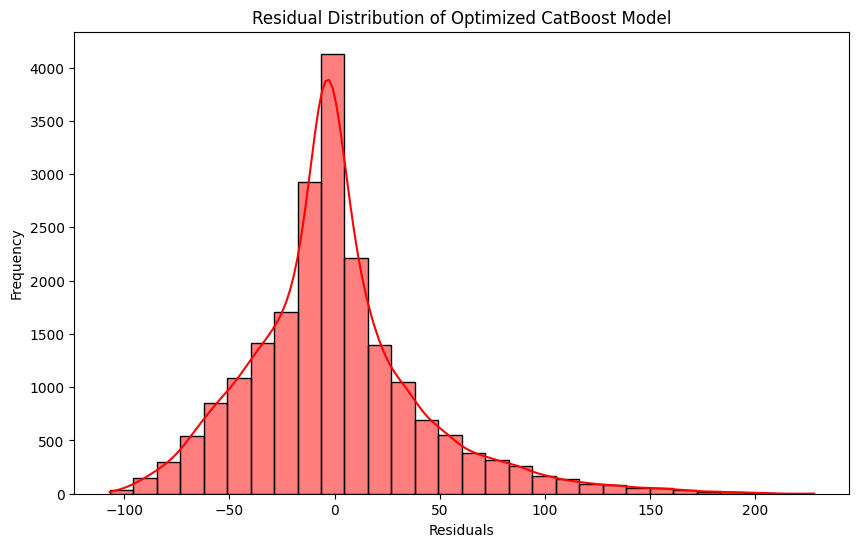

In [217]:
# Residual Plot
plt.figure(figsize=(10, 6))
sns.histplot(y - y_pred, bins=30, kde=True, color='red')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title(f'Residual Distribution of Optimized CatBoost Model')
plt.show()


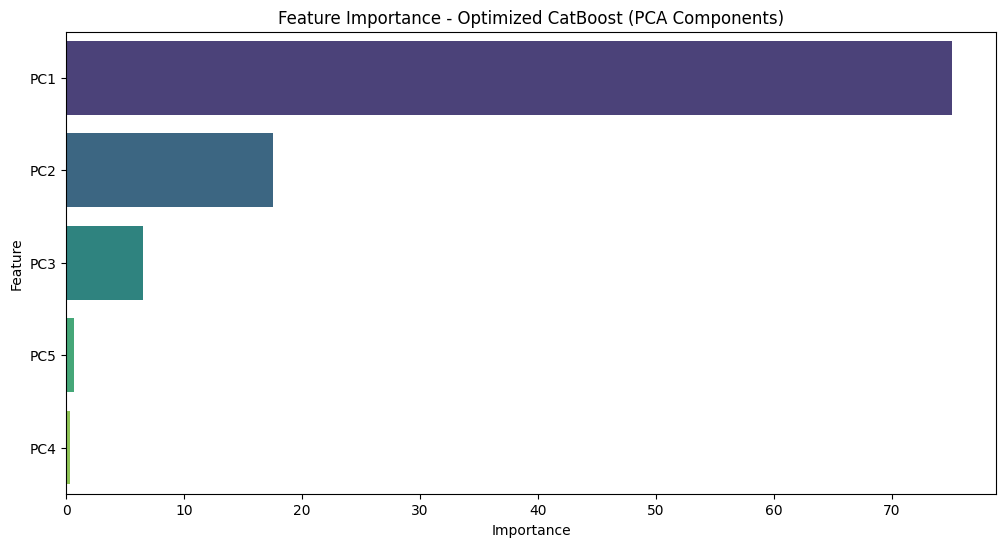

In [218]:
# Feature Importance Plot
importances = best_model.get_feature_importance()
feature_names = [f'PC{i+1}' for i in range(X_pca.shape[1])]
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')
plt.title('Feature Importance - Optimized CatBoost (PCA Components)')
plt.show()